# お弁当予測tutorial手順の実施
結果の精度は10.59700

## 事前準備

In [1]:
#基本モジュールのインポート
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


### matplotlibとseabornの日本語対応

In [33]:
#グラフ描画時にmatplotlibとseabornに日本語フォントを表示するための処理
import matplotlib.font_manager as fm
import matplotlib as mpl

#matplotlibのconfigの格納ディレクトリを確認
print(mpl.matplotlib_fname())

#matplotlibの使用可能フォントの確認
font_paths = mpl.font_manager.findSystemFonts()
font_objects = mpl.font_manager.createFontList(font_paths)
font_names = [f.name for f in font_objects]
print(font_names)



['Liberation Serif', 'Liberation Sans Narrow', 'Liberation Mono', 'Liberation Sans Narrow', 'Liberation Mono', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Mono', 'Liberation Sans', 'Liberation Serif', 'Liberation Serif', 'Liberation Mono', 'Liberation Sans Narrow', 'Liberation Serif', 'Liberation Sans', 'Liberation Sans']


#実行時はセルをコードに書き換えて
#日本語フォントを利用するにはIPAexGothicが必要なのでIPAのサイトよりダウンロードする
import urllib.request
import sys
#URL
urllib.request.urlretrieve("https://ipafont.ipa.go.jp/old/ipaexfont/ipaexg00201.php",'hoge.zip')

#実行時はセルをコードに書き換えて
#IPAexGothicのファイルを所定のフォルダにコピーする
%%bash
ls
pwd
unzip hoge.zip
cp /home/jovyan/work/ipaexg00201/ipaexg.ttf /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf
ls /opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf

#設定ファイルの書き換えとキャッシュファイルのクリアが必要となるのでconsoleを使用する必要あり
手順は整理中なので整理が終わったらnoteに書く
jupyter-notebookにviが入っていなかったのでダウンロード
apt-get install vim

フォントファイルについてはキャッシュが残っているとそちらが優先されるので、以下のfolderからキャッシュファイルを削除
~/.matplotlib/
commandは以下
rm ファイル名


In [5]:
sns.set(font="IPAexGothic",style="white")

## データ読み込み

In [6]:
train = pd.read_csv("./Input/train.csv")
test = pd.read_csv("./Input/test.csv")
sample = pd.read_csv("./Input/sample.csv",header=None)
print("Data Shapes")
print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Data Shapes
Train: (207, 12) Test: (40, 11) Sample: (40, 2)


### データ傾向確認
前処理の前にまずは簡単にデータ傾向を調査する

In [7]:
#日時をインデックスに設定
train.index = pd.to_datetime(train["datetime"])
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,,
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
2013-11-19,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2013-11-20,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
2013-11-21,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
2013-11-22,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [8]:
train.describe()

,y,soldout,kcal,payday,temperature
count,207.000000,207.000000,166.000000,10.0,207.000000
mean,86.623188,0.449275,404.409639,1.0,19.252174
std,32.882448,0.498626,29.884641,0.0,8.611365
min,29.000000,0.000000,315.000000,1.0,1.200000
25%,57.000000,0.000000,386.000000,1.0,11.550000
50%,78.000000,0.000000,408.500000,1.0,19.800000
75%,113.000000,1.000000,426.000000,1.0,26.100000
max,171.000000,1.000000,462.000000,1.0,34.600000


In [9]:
#データ内のカーディナリティ（説明変数ごとの値の数）
train.describe(include="O")

,datetime,week,name,remarks,event,weather,precipitation
count,207,207,207,21,14,207,207
unique,207,5,156,6,2,7,8
top,2014-6-19,水,メンチカツ,お楽しみメニュー,ママの会,快晴,--
freq,1,43,6,12,9,53,169


## 前処理

### 欠損値埋め&特徴量作成（簡単なやつ）

In [10]:
#paydayはフラグないところがすべてnullなので0埋めを実施
train["payday"] = train["payday"].fillna(0)
#降水量は数値データとして扱いたい。天候が雨以外の降水量"--"を-1に置換。（雨で降水量0の日があるため）
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x))
#eventない日は"なし"に設定
train["event"] = train["event"].fillna("なし")
#remarksない場合は"なし"に設定
train["remarks"] = train["remarks"].fillna("なし")
#特徴量：月を作成
train["month"] = train["datetime"].apply(lambda x : int(x.split("-")[1]))

### データ確認（欠損値処理後）

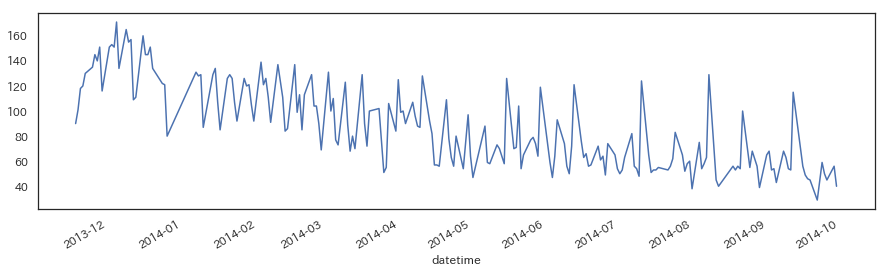

In [11]:
#売上の傾向確認
train["y"].plot(figsize=(15,4))

売り上げは下降傾向にあるが、スパイクがあるため、何かしら増加要因がある

### 目的変数と説明変数（数値変数）との散布図の確認

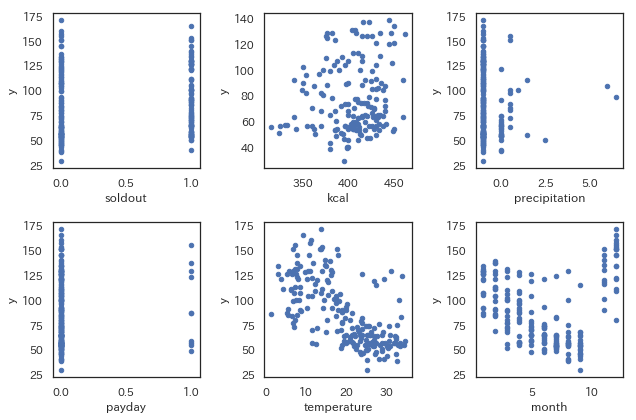

In [12]:
fig, ax = plt.subplots(2,3,figsize=(9,6))
train.plot.scatter(x="soldout", y="y", ax=ax[0][0])
train.plot.scatter(x="kcal", y="y", ax=ax[0][1])
train.plot.scatter(x="precipitation", y="y", ax=ax[0][2])
train.plot.scatter(x="payday", y="y", ax=ax[1][0])
train.plot.scatter(x="temperature", y="y", ax=ax[1][1])
train.plot.scatter(x="month", y="y", ax=ax[1][2])
plt.tight_layout()

temperature,monthは相関がありそう

### 目的変数と説明変数（カテゴリー変数）との箱ひげ図の確認

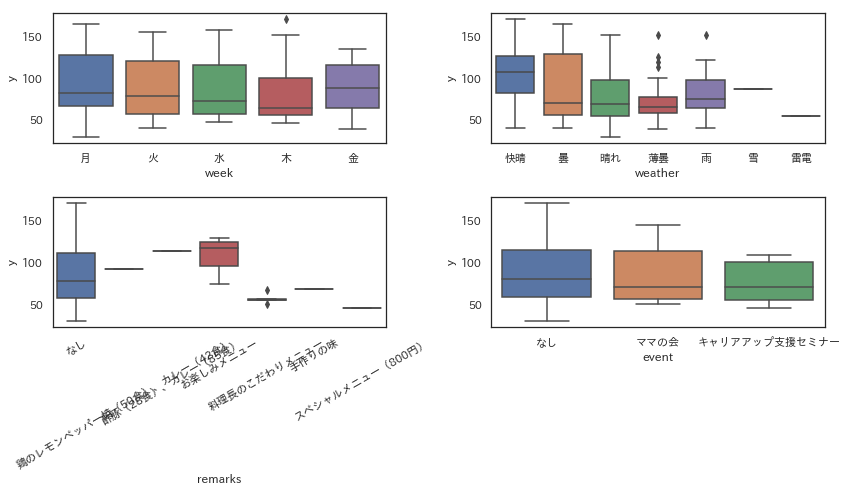

In [13]:
fig, ax = plt.subplots(2,2,figsize=(12,7))
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="weather",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=30)
sns.boxplot(x="event",y="y",data=train,ax=ax[1][1])
plt.tight_layout()

お楽しみメニューの時売り上げが高いので、お楽しみメニュー以外の時の傾向を確認

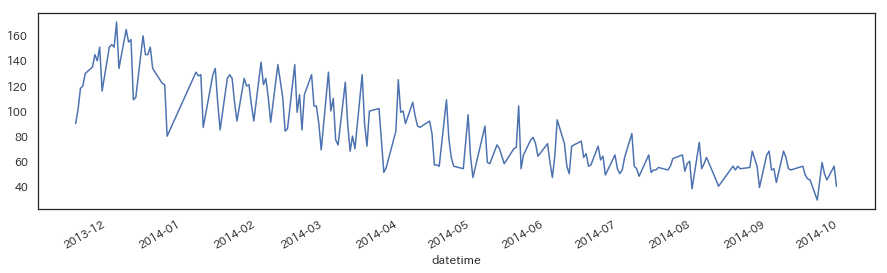

In [14]:
train[train["remarks"]!="お楽しみメニュー"]["y"].plot(figsize=(15,4))

売り上げを押し上げていたスパイクが消えた

### 特徴量作成（お楽しみメニュー）

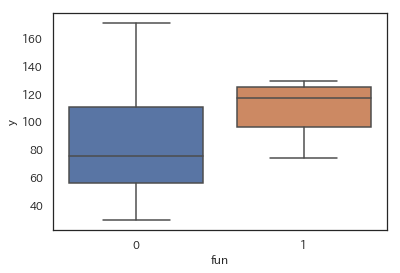

In [15]:
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
sns.boxplot(x="fun",y="y",data=train)

In [16]:
from scipy.stats import median_test
#戻り値は左からstat:カイ二乗統計量,p:p値,med:自由度,tbl:期待度数の表
stat,p,med,tbl = median_test(train[train["fun"]==1]["y"],train[train["fun"]==0]["y"])
print("p",p,"stat",stat)

p 0.00705796076625 stat 7.25815898417


お楽しみメニューと其の他は独立か否かという検定。
p値は0.05以下であれば、伝統的に独立といえる
↓参考
https://logics-of-blue.com/chi-squared-test/
↓自由度の説明
https://to-kei.net/hypothesis-testing/degree-of-freedom-of-contingency-table/

お楽しみメニュー内でも傾向がないか確認する

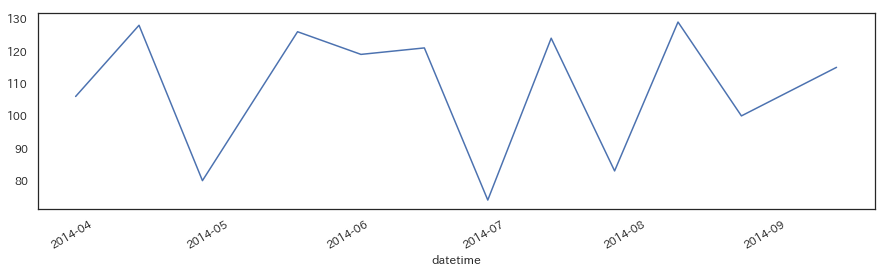

In [17]:
train[train["remarks"]=="お楽しみメニュー"]["y"].plot(figsize=(15,4))

お楽しみメニュー内でもアップダウンが発生しているため、お楽しみメニューの値を確認

In [18]:
train[train["remarks"]=="お楽しみメニュー"]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month,fun
datetime,,,,,,,,,,,,,,
2014-03-28,2014-3-28,106,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,18.5,3,1
2014-04-11,2014-4-11,128,金,1,チキンカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,16.5,4,1
2014-04-25,2014-4-25,80,金,0,中華丼,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,20.8,4,1
2014-05-16,2014-5-16,126,金,0,ポークカレー,NaN,お楽しみメニュー,ママの会,0.0,快晴,-1.0,23.8,5,1
2014-05-30,2014-5-30,119,金,0,チキンカレー,NaN,お楽しみメニュー,なし,0.0,薄曇,-1.0,26.9,5,1
2014-06-13,2014-6-13,121,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,29.5,6,1
2014-06-27,2014-6-27,74,金,0,牛丼,NaN,お楽しみメニュー,なし,0.0,雨,0.0,25.4,6,1
2014-07-11,2014-7-11,124,金,0,ポークカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.9,7,1
2014-07-25,2014-7-25,83,金,0,ひやしたぬきうどん・炊き込みご飯,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.6,7,1


### 特徴量作成（カレー）
カレーが多いので、カレーの傾向を確認

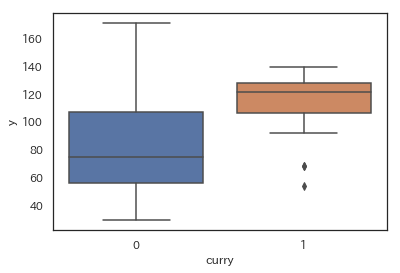

In [19]:
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
sns.boxplot(x="curry",y="y",data=train)

カレーか否かは有意差がありそう

In [20]:
stat,p,med,tbl = median_test(train[train["curry"]==1]["y"],train[train["curry"]==0]["y"])
print("p:",p,"stat",stat)

p: 0.0106997429009 stat 6.51451616283


p値が0.05以下なので優位とみてもよさそう

# ここからデータ検定実施
    ・方針としては日数が経過するにつれて減衰している為、売上数と日数の単回帰モデルを軸に検討する
    ・但し、2014-05以前はやや傾向が異なる為、学習データから除く
    ・他、お楽しみメニューやカレー等は大きく寄与はしていそうだが、非線形な関係であることも考慮し、Random Forestを用いて単回帰モデルの結果を修正するモデルも作成し、予測結果を導出することにする

In [21]:
train = pd.read_csv("./Input/train.csv")
test = pd.read_csv("./Input/test.csv")
sample = pd.read_csv("./Input/sample.csv",header=None)

In [22]:
#trainとtestデータの両方に一括で前処理をかけるために結合する。結合のために判別できるようフラグtを挿入
train["t"] = 1
test["t"] = 0
#データの結合 冗長だけどtrainとtestで天気の属性値の数に違いがあるため、別個でやると後で説明変数の数がずれてしまう
dat = pd.concat([train,test],sort=True).reset_index(drop=True)

In [36]:
#インデックスに月日を設定
dat.index = pd.to_datetime(dat["datetime"])
#2014年5月より後のデータを抽出dat[a:b]でa～bの範囲のデータを抽出
dat = dat["2014-05-01":]
#インデックスを振りなおす。drop=True を指定しなければ、旧インデックスがデータ列に移動
dat = dat.reset_index(drop=True)

#daysという特徴量を設定
dat["days"] = dat.index
#データ確認にて作成することとした特徴量を作成
dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)
dat["fun"] = dat["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
dat["curry"] = dat["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

#調べたい特長量（説明変数はcolsで規定する）
cols = ["precipitation","weather","days","fun","curry","y"]

In [24]:
#sklearnで使用するパッケージをインポート
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [56]:
#モデルの訓練を実施
def learning(trainX,y_train):
    model1 = LR()
    model2 = RF(n_estimators=100,max_depth=4,random_state=777)
    model1.fit(trainX["days"].values.reshape(-1,1),y_train)
    pred = model1.predict(trainX["days"].values.reshape(-1,1))
    pred_sub = y_train - pred
    model2.fit(trainX.iloc[:, ~trainX.columns.str.match("y")],pred_sub)
    return model1, model2

In [57]:
#k-fold cross varidationを行う

#分割数とランダムシードを設定
kf = KFold(n_splits=5,random_state=777)
#トレインデータを格納
tr = dat[dat["t"]==1][cols]
trains = []
tests = []

#trのデータ数が100なので、80:20にデータを分けてcross varidationスタート。5回。testに1-20,20-40,40-60,60-80,80-100と値が入る
for train_index, test_index in kf.split(tr):
    #trainとtestにフラグを設定
    tr.loc[train_index,"tt"] = 1
    tr.loc[test_index,"tt"] = 0
    tr["tt"] = tr["tt"].astype(np.int)
    #カテゴリ変数はそのまま扱えないのでダミー変数化する
    tmp = pd.get_dummies(tr)
    
    trainX = tmp[tmp["tt"]==1]
    del trainX["tt"]
    testX = tmp[tmp["tt"]==0]
    del testX["tt"]
    y_train = tmp[tmp["tt"]==1]["y"]
    y_test = tmp[tmp["tt"]==0]["y"]
    
    model1, model2 = learning(trainX, y_train)
    #予測の実施
    pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:, ~trainX.columns.str.match("y")])
    pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:, ~testX.columns.str.match("y")])
    
    print("TRAIN:",MSE(y_train,pred_train)**0.5, "VARIDATE",MSE(y_test, pred_test)**0.5)
    trains.append(MSE(y_train,pred_train)**0.5)
    tests.append(MSE(y_test, pred_test)**0.5)
print("AVG")
print(np.array(trains).mean(), np.array(tests).mean())

TRAIN: 7.56704589058 VARIDATE 12.1085127329
TRAIN: 7.89887980939 VARIDATE 10.5960249087
TRAIN: 8.26627424909 VARIDATE 8.84307566418
TRAIN: 7.95459968587 VARIDATE 19.9320555131
TRAIN: 7.91391888378 VARIDATE 9.44346682395
AVG
7.92014370374 12.1846271286


In [27]:
cols = ["precipitation","weather","days","fun","curry","y","t"]
tmp = pd.get_dummies(dat[cols])
trainX = tmp[tmp["t"]==1]
del trainX["t"]
testX = tmp[tmp["t"]==0]
del testX["t"]
y_train = tmp[tmp["t"]==1]["y"]
y_test = tmp[tmp["t"]==0]["y"]

RMSE 7.98622990842


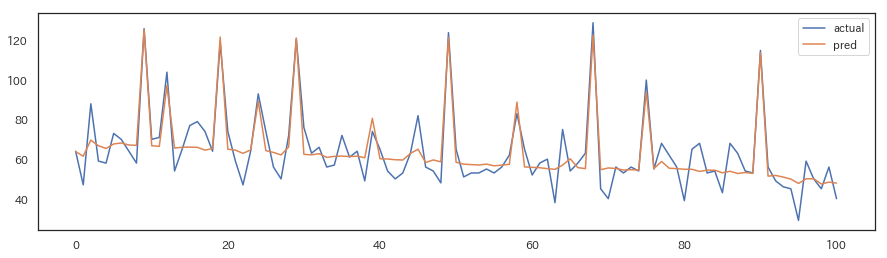

In [28]:
model1, model2 = learning(trainX,y_train)
pred = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:,~trainX.columns.str.match("y")])

p = pd.DataFrame({"actual":y_train,"pred":pred})
p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred)**0.5)

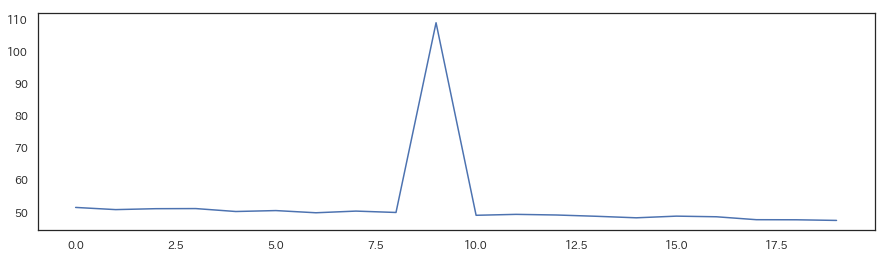

In [62]:
model1, model2 = learning(trainX,y_train)
pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
plt.figure(figsize=(15,4))
plt.plot(pred)

In [30]:
sample[1] = pred
sample.to_csv("./Output/submit01.csv",index=None,header=None)